In [ ]:
import obspy
from obspy import read
from obspy import Trace, Stream
import h5py
from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as plt

from matplotlib import mlab
from matplotlib.colors import Normalize
from obspy.imaging.cm import obspy_sequential
import os

import string
import argparse as ap
import sys
import os
import numpy as np

import obspy
import obspy.core as oc
from obspy import read_inventory

# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
import warnings

mpl.rcParams['pdf.fonttype'] = 42

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
from google.colab import drive  # Import for Google Drive access
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

def build_stream(df, h5, filt, freq_min, freq_max):

    all_st = obspy.Stream()  # Create an empty stream

    for line in range(len(df)):  # Loop over all events

        row = df.iloc[line, :]
        waveform = h5['data'][row['trace_name']]
        stats = oc.Stats()
        stats.npts = 12000
        stats.sampling_rate = 100.

        sta = row['station_code']
        net = row['station_network_code']



        stats.delta = row['trace_dt_s']
        stats.starttime = UTCDateTime(row['trace_start_time'])  # Use ObsPy UTCDateTime
        stats.network = net
        stats.station = sta

        stats.category = row['trace_category']

        if row['trace_P_arrival_time'] in ["", "None", "null"]:
            stats.p_arrival_time = None
        else:
            stats.p_arrival_time = UTCDateTime(row['trace_P_arrival_time'])

        if row['trace_S_arrival_time'] in ["", "None", "null"]:
            stats.s_arrival_time = None
        else:
            stats.s_arrival_time = UTCDateTime(row['trace_S_arrival_time'])


        st = obspy.Stream()
        for i in range(3):
            tr = obspy.Trace()
            tr.data = waveform[i]
            tr.stats = stats.copy()  # Copy stats to avoid overwriting

            if i == 0:
                tr.stats.channel = row['station_channels'] + 'E'
                tr.stats.SNR = row['trace_E_snr_db']
            elif i == 1:
                tr.stats.channel = row['station_channels'] + 'N'
                tr.stats.SNR = row['trace_N_snr_db']
            elif i == 2:
                tr.stats.channel = row['station_channels'] + 'Z'
                tr.stats.SNR = row['trace_Z_snr_db']

            st.append(tr)

        all_st += st  # Append the event stream to the main stream

    if filt:
        all_st.detrend(type='linear')
        all_st.filter(type='bandpass', freqmin=freq_min, freqmax=freq_max)

    return all_st, row

def counts_to_vel(df, h5, filt, freq_min, freq_max, client):

    all_st = obspy.Stream()  # Create an empty stream
    failed_events = []  # List to track failed response removals

    for line in range(len(df)):  # Loop over all events
        row = df.iloc[line, :]

        stats = oc.Stats()
        stats.npts = 12000
        stats.sampling_rate = 100.0

        sta = row['station_code']
        net = row['station_network_code']
        trace_name = row['trace_name']
        waveform = h5['data'][trace_name]

        stats.delta = row['trace_dt_s']
        stats.starttime = UTCDateTime(row['trace_start_time'])  # Convert to ObsPy time
        stats.network = net
        stats.station = sta
        stats.category = row['trace_category']
        stats.p_arrival_time = None
        stats.s_arrival_time = None

        # Fetch response metadata
        try:
            inventory = client.get_stations(
                network=net,
                station=sta,
                starttime=stats.starttime,
                endtime=stats.starttime + 120,  # Add 120 seconds
                loc="*",
                channel="*",
                level="response"
            )
        except Exception as e:
            print(f"Failed to get response for event {trace_name}: {e}")
            failed_events.append(trace_name)
            continue  # Skip this event if inventory retrieval fails

        st = obspy.Stream()
        for i in range(3):
            tr = obspy.Trace()
            tr.data = waveform[i]
            tr.stats = stats.copy()  # Copy stats to avoid modifying reference

            if i == 0:
                tr.stats.channel = row['station_channels'] + 'E'
            elif i == 1:
                tr.stats.channel = row['station_channels'] + 'N'
            elif i == 2:
                tr.stats.channel = row['station_channels'] + 'Z'

            st.append(tr)

        # Try to remove response
        try:
            st.remove_response(inventory=inventory, output="VEL", plot=False)
        except Exception as e:
            failed_events.append(trace_name)
            continue  # Skip this event if response removal fails

        all_st += st  # Append processed event stream to the main stream

    # Apply filtering if requested
    if filt:
        all_st.detrend(type='linear')
        all_st.filter(type='bandpass', freqmin=freq_min, freqmax=freq_max)

    return all_st, failed_events, row


def split(word):
    chars = [char for char in word]
    charsout = []
    for c in chars:
        charsout.append('(' + c + ')')
    return charsout



In [ ]:

def trace_slice(original_trace):
    p_arrival_time = original_trace.stats.p_arrival_time
    s_arrival_time = original_trace.stats.s_arrival_time

    # Split into 4 slices of 3000 samples (30 seconds each at 100Hz)
    samples_per_window = 3000
    sampling_rate = original_trace.stats.sampling_rate

    sliced_traces = Stream()

    for i in range(4):
        start_sample = i * samples_per_window
        end_sample = start_sample + samples_per_window

        sliced_data = original_trace.data[start_sample:end_sample]

        new_start_time = original_trace.stats.starttime + (start_sample / sampling_rate)

        new_trace = Trace(data=sliced_data, header=original_trace.stats.copy())
        new_trace.stats.starttime = new_start_time
        new_trace.stats.npts = len(sliced_data)

        # P-phase
        if new_start_time <= p_arrival_time <= new_trace.stats.endtime:
            relative_p_arrival = p_arrival_time - new_start_time
            print(f"Slice {i}: P-phase at {relative_p_arrival:.2f} seconds in window")
            new_trace.stats.p_phase_relative_time = relative_p_arrival
        else:
            new_trace.stats.p_phase_relative_time = None

        # S-phase
        if new_start_time <= s_arrival_time <= new_trace.stats.endtime:
            relative_s_arrival = s_arrival_time - new_start_time
            print(f"Slice {i}: S-phase at {relative_s_arrival:.2f} seconds in window")
            new_trace.stats.s_phase_relative_time = relative_s_arrival
        else:
            new_trace.stats.s_phase_relative_time = None

        sliced_traces.append(new_trace)

    return sliced_traces

def stream_slice(stream):
    sliced_stream = Stream()
    for trace in stream:
        sliced_traces = trace_slice(trace)
        sliced_stream.extend(sliced_traces)
    return sliced_stream


In [ ]:

def trace_slice_noise(original_trace):
    #p_arrival_time = original_trace.stats.p_arrival_time
    #s_arrival_time = original_trace.stats.s_arrival_time

    # Split into 4 slices of 3000 samples (30 seconds each at 100Hz)
    samples_per_window = 3000
    sampling_rate = original_trace.stats.sampling_rate

    sliced_traces = Stream()

    for i in range(4):
        start_sample = i * samples_per_window
        end_sample = start_sample + samples_per_window

        sliced_data = original_trace.data[start_sample:end_sample]

        new_start_time = original_trace.stats.starttime + (start_sample / sampling_rate)

        new_trace = Trace(data=sliced_data, header=original_trace.stats.copy())
        new_trace.stats.starttime = new_start_time
        new_trace.stats.npts = len(sliced_data)
        sliced_traces.append(new_trace)

        """
        # P-phase
        if new_start_time <= p_arrival_time <= new_trace.stats.endtime:
            relative_p_arrival = p_arrival_time - new_start_time
            print(f"Slice {i}: P-phase at {relative_p_arrival:.2f} seconds in window")
            new_trace.stats.p_phase_relative_time = relative_p_arrival
        else:
            new_trace.stats.p_phase_relative_time = None

        # S-phase
        if new_start_time <= s_arrival_time <= new_trace.stats.endtime:
            relative_s_arrival = s_arrival_time - new_start_time
            print(f"Slice {i}: S-phase at {relative_s_arrival:.2f} seconds in window")
            new_trace.stats.s_phase_relative_time = relative_s_arrival
        else:
            new_trace.stats.s_phase_relative_time = None

        sliced_traces.append(new_trace)
        """

    return sliced_traces

def stream_slice_noise(stream):
    sliced_stream = Stream()
    for trace in stream:
        sliced_traces = trace_slice_noise(trace)
        sliced_stream.extend(sliced_traces)
    return sliced_stream


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import specgram

def compute_dominant_frequencies(data, fs=100.0, window_length=200, hop_size=14, desired_frames=200, plot=False, title=None):
    """
    Compute STFT and extract dominant frequency per timeframe.

    Parameters:
        data (np.ndarray): Input 1D signal.
        fs (float): Sampling frequency in Hz.
        window_length (int): STFT window size.
        desired_frames (int): Number of desired timeframes.
        plot (bool): If True, show the spectrogram and dominant frequencies.

    Returns:
        time_bins (np.ndarray): Time (in seconds) for each STFT frame.
        dominant_freqs (np.ndarray): Dominant frequency for each timeframe.
    """
    #signal = data
    signal = data - np.mean(data)

    # Calculate hop size to get desired number of frames
    hop_size = hop_size
    noverlap = window_length - hop_size
    window = np.hanning(window_length)

    Pxx, freqs, time_bins = specgram(
        signal,
        NFFT=window_length,
        Fs=fs,
        window=window,
        noverlap=noverlap
    )

    #Pxx = Pxx[1:, :]     # remove DC component
    #freqs = freqs[1:]    # remove DC frequency

    dominant_indices = np.argmax(Pxx, axis=0)
    dominant_freqs = freqs[dominant_indices]

    # Ensure exactly desired_frames by slicing the first 200
    time_bins = time_bins[:desired_frames]
    dominant_freqs = dominant_freqs[:desired_frames]
    Pxx = Pxx[:, :desired_frames]  # Slice the spectrogram data too

    #time_bins = time_bins[:]
    #dominant_freqs = dominant_freqs[:]
    #Pxx = Pxx[:, :]  # Slice the spectrogram data too

    if plot:
        plt.figure(figsize=(10, 4))
        plt.pcolormesh(time_bins, freqs, Pxx, shading='gouraud')
        plt.plot(time_bins, dominant_freqs, color='red', label='Dominant Frequency')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [s]')
        plt.title(f"{title} - Spectrogram (Linear Power)")
        plt.colorbar(label='Power')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return time_bins, dominant_freqs


In [ ]:

def trace_dominant_frequencies(trace, **kwargs):
    """
    Extract dominant frequencies from a seismic trace.

    Parameters:
    - trace (obspy.Trace): Seismic trace from which to extract dominant frequencies.
    - kwargs: Additional parameters for `extract_dominant_frequencies`.

    Returns:
    - List of dominant frequencies extracted every 0.2 seconds.
    """
    freq = []
    freq_modified = []
    time_modified = []

    if 'title' not in kwargs:
            kwargs['title'] = str(trace.id)

    freq = compute_dominant_frequencies(data=trace.data, **kwargs)

    for i in range(len(freq)):
      if i == 0:
        for idx in range(len(freq[i])):
          for j in range(15):
            time_modified.append(freq[i][idx])

      if i == 1:
        for idx in range(len(freq[i])):
          for j in range(15):
            freq_modified.append(freq[i][idx])

    index = np.arange(len(time_modified)) * 0.01

    return index, freq_modified #seharusnya return index t


def stream_dominant_frequencies(stream, **kwargs):
    """
    Extract dominant frequencies for each trace in the given stream.

    Parameters:
    - stream (obspy.Stream): The seismic stream containing multiple traces.
    - kwargs: Additional parameters for `trace_dominant_frequencies`.

    Returns:
    - List of dominant frequency lists, one for each trace in the stream.

    Example:
    >>> from obspy import read
    >>> st = read()
    >>> freqs = stream_dominant_frequencies(st)
    """
    spec_list = []
    for tr in stream:
        spec = trace_dominant_frequencies(tr, **kwargs)
        spec_list.append(spec)

    return spec_list

In [ ]:
def create_dataset(data):
    """
    Extract dominant frequencies for each trace in the given stream.

    Parameters:
    - stream (obspy.Stream): The seismic stream containing multiple traces.
    - kwargs: Additional parameters for `trace_dominant_frequencies`.

    Returns:
    - List of dominant frequency lists, one for each trace in the stream.

    Example:
    >>> from obspy import read
    >>> st = read()
    >>> freqs = stream_dominant_frequencies(st)
    """
    # Convert to LSTM-friendly format
    X = np.array([features for _, features in data])

    # Reshape to (num_samples, timesteps, num_features)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Assuming 1 feature per timestep

    print(X.shape)  # Expected: (num_samples, timesteps, num_features)

    return X

def trace_labels(trace, time, show=False):
    import numpy as np
    import matplotlib.pyplot as plt

    duration = trace.stats.endtime - trace.stats.starttime

    t_start = 0
    t_end = t_start + duration
    #sampling_rate = trace.stats.sampling_rate

    num_samples = len(trace.data)
    t = np.linspace(t_start, t_end, num_samples, endpoint=True)
    #t = np.array(time)  # ✅ Ensure time is a NumPy array
    square_wave = np.zeros_like(t)

    p_arrival = trace.stats.p_phase_relative_time
    s_arrival = trace.stats.s_phase_relative_time

    if p_arrival is not None:
        pulse_start = t_start + p_arrival

        if s_arrival is not None:
            duration_after = s_arrival - p_arrival
            pulse_end = pulse_start + duration_after
        else:
            pulse_end = t_end

        square_wave[(t >= pulse_start) & (t <= pulse_end)] = 1
    else:
        pulse_start = 0
        pulse_end = 0

    if show:
        plt.plot(np.arange(len(square_wave)), square_wave, label="Ground Truth")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.title("Square Impulse Wave")
        plt.legend()
        plt.grid(True)
        plt.show()

    return t, square_wave

def stream_labels(stream, show=False):
    """
    Extract dominant frequencies for each trace in the given stream.

    Parameters:
    - stream (obspy.Stream): The seismic stream containing multiple traces.
    - kwargs: Additional parameters for `trace_dominant_frequencies`.

    Returns:
    - List of dominant frequency lists, one for each trace in the stream.

    Example:
    >>> from obspy import read
    >>> st = read()
    >>> freqs = stream_dominant_frequencies(st)
    """
    labels_list = []
    for tr in stream:
        labels = trace_labels(tr, time, show)
        labels_list.append(labels)

    return labels_list

def noise_labels(trace, time, show=False):
    duration = trace.stats.endtime - trace.stats.starttime

    t_start = 0
    t_end = t_start + duration
    #sampling_rate = trace.stats.sampling_rate

    # Convert sample count to an integer
    num_samples = len(trace.data)

    t = np.linspace(t_start, t_end, num_samples, endpoint=True)
    #t = time
    square_wave = np.zeros_like(t)
    """
    if trace.stats.p_arrival_time is not None:
      duration_before = trace.stats.p_arrival_time - trace.stats.starttime
      pulse_start = t_start + duration_before

      if trace.stats.s_arrival_time is not None:
        duration_after = trace.stats.s_arrival_time - trace.stats.p_arrival_time
        pulse_end = pulse_start + duration_after
      else:
        pulse_end = t_end

      square_wave[(t >= pulse_start) & (t <= pulse_end)] = 0

    else:
      pulse_start = 0
      pulse_end = 0
    """
    pulse_start = 0
    pulse_end = 0
    square_wave[(t >= pulse_start) & (t <= pulse_end)] = 0

    if show:
        plt.plot(np.arange(len(square_wave)), square_wave, label="Ground Truth")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.title("Square Impulse Wave")
        plt.legend()
        plt.grid(True)
        plt.show()

    return t, square_wave

def noise_stream_labels(stream, show=False):
    """
    Extract dominant frequencies for each trace in the given stream.

    Parameters:
    - stream (obspy.Stream): The seismic stream containing multiple traces.
    - kwargs: Additional parameters for `trace_dominant_frequencies`.

    Returns:
    - List of dominant frequency lists, one for each trace in the stream.

    Example:
    >>> from obspy import read
    >>> st = read()
    >>> freqs = stream_dominant_frequencies(st)
    """
    labels_list = []
    for tr in stream:
        labels = noise_labels(tr, time, show)
        labels_list.append(labels)

    return labels_list




In [ ]:
warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42

FIGDIR='/content/drive/MyDrive/data_codingan_skripsi/figure'


# file NAMES
# MetaData
events_metaname=os.path.join('/content/drive/MyDrive/data_codingan_skripsi/events_filtered_metadata.csv')
#noise_metaname=os.path.join('/content/drive/MyDrive/data_codingan_skripsi/noise_metadata.csv')
# HDF5
events_hdfname=os.path.join('/content/drive/MyDrive/data_codingan_skripsi/merged_events.h5')
#noise_hdfname=os.path.join('/content/drive/MyDrive/data_codingan_skripsi/merged_noise_data.h5')
# Figures
# events_figname=os.path.join(FIGDIR,'waveforms_Evs.png')
# gm_figname=os.path.join(FIGDIR,'waveforms_Evs_gm.png')
# noise_figname=os.path.join(FIGDIR,'waveforms_Noise.png')

events_metaData = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object,
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object,
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object},
                             low_memory=False)

#noise_metaData = pd.read_csv(noise_metaname,dtype={'station_location_code': object}, low_memory=False)

events_h5File = h5py.File(events_hdfname, 'r') # Events in gm
#noise_h5File = h5py.File(noise_hdfname, 'r')   # Noise in counts

In [ ]:
events_metaData.drop_duplicates(subset='trace_name', keep='first', inplace=True)
events_metaData.reset_index(drop=True, inplace=True)

In [ ]:
events, row_events = build_stream(events_metaData,events_h5File, False, 0, 10000)


In [ ]:
noise = read("/content/drive/MyDrive/data_codingan_skripsi/noise_gm.mseed", format="MSEED")

In [ ]:
noise.filter("bandpass", freqmin=1.0, freqmax=45.0)


2607 Trace(s) in Stream:

IV.ORZI..HNE | 2013-12-05T21:08:54.345000Z - 2013-12-05T21:10:54.335000Z | 100.0 Hz, 12000 samples
...
(2605 other traces)
...
IV.EPZF..HHZ | 2013-12-22T03:44:55.410000Z - 2013-12-22T03:46:55.400000Z | 100.0 Hz, 12000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [ ]:
events.filter("bandpass", freqmin=1.0, freqmax=45.0)


16230 Trace(s) in Stream:

IV.OFFI..HHE | 2016-12-04T15:34:43.920000Z - 2016-12-04T15:36:43.910000Z | 100.0 Hz, 12000 samples
...
(16228 other traces)
...
IV.VCEL..EHZ | 2016-12-09T12:12:53.260000Z - 2016-12-09T12:14:53.250000Z | 100.0 Hz, 12000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [ ]:
events.count()

16230

In [ ]:
noise.count()

2607

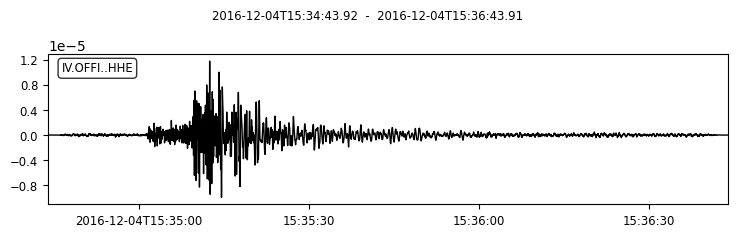

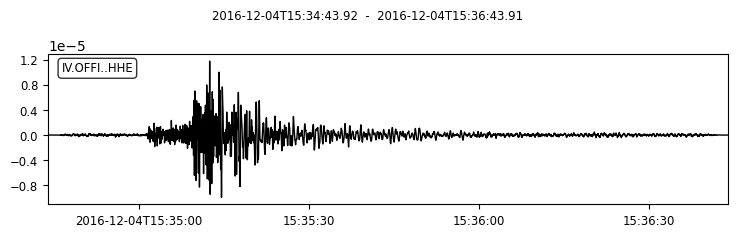

In [ ]:
events[0].plot()

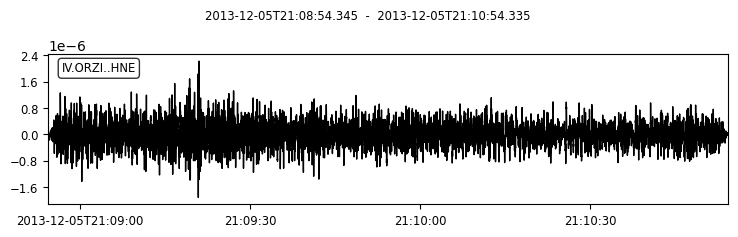

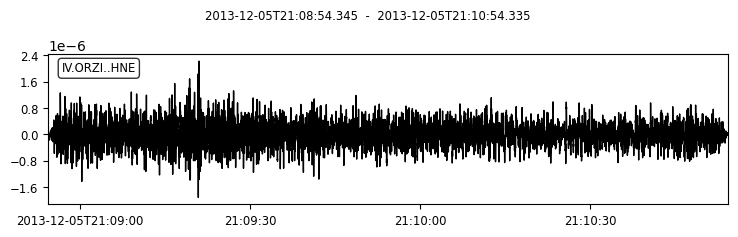

In [ ]:
noise[0].plot()

In [ ]:
events[0].stats

         network: IV
         station: OFFI
        location: 
         channel: HHE
       starttime: 2016-12-04T15:34:43.920000Z
         endtime: 2016-12-04T15:36:43.910000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12000
           calib: 1.0
             SNR: 15.1587976669
        category: earthquake
  p_arrival_time: 2016-12-04T15:35:01.270000Z
      processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]
  s_arrival_time: None

In [ ]:
noise[0].stats

         network: IV
         station: ORZI
        location: 
         channel: HNE
       starttime: 2013-12-05T21:08:54.345000Z
         endtime: 2013-12-05T21:10:54.335000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 256278528})
      processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]

# slice traces into 30 sec duration each trace

## events sliced

In [ ]:
sliced_traces = trace_slice(events[8])

Slice 0: P-phase at 16.79 seconds in window
Slice 0: S-phase at 23.66 seconds in window


In [ ]:
len(sliced_traces)

4

In [ ]:
events[8].stats

         network: IV
         station: RM33
        location: 
         channel: EHZ
       starttime: 2016-12-04T15:34:43.690000Z
         endtime: 2016-12-04T15:36:43.680000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12000
           calib: 1.0
             SNR: 25.7669861028
        category: earthquake
  p_arrival_time: 2016-12-04T15:35:00.480000Z
      processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]
  s_arrival_time: 2016-12-04T15:35:07.350000Z

In [ ]:
sliced_traces[0].stats

              network: IV
              station: RM33
             location: 
              channel: EHZ
            starttime: 2016-12-04T15:34:43.690000Z
              endtime: 2016-12-04T15:35:13.680000Z
        sampling_rate: 100.0
                delta: 0.01
                 npts: 3000
                calib: 1.0
                  SNR: 25.7669861028
             category: earthquake
       p_arrival_time: 2016-12-04T15:35:00.480000Z
p_phase_relative_time: 16.79
           processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]
       s_arrival_time: 2016-12-04T15:35:07.350000Z
s_phase_relative_time: 23.66

In [ ]:
sliced_traces[1].stats

              network: IV
              station: RM33
             location: 
              channel: EHZ
            starttime: 2016-12-04T15:35:13.690000Z
              endtime: 2016-12-04T15:35:43.680000Z
        sampling_rate: 100.0
                delta: 0.01
                 npts: 3000
                calib: 1.0
                  SNR: 25.7669861028
             category: earthquake
       p_arrival_time: 2016-12-04T15:35:00.480000Z
p_phase_relative_time: None
           processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]
       s_arrival_time: 2016-12-04T15:35:07.350000Z
s_phase_relative_time: None

In [ ]:
len(sliced_traces[0])

3000

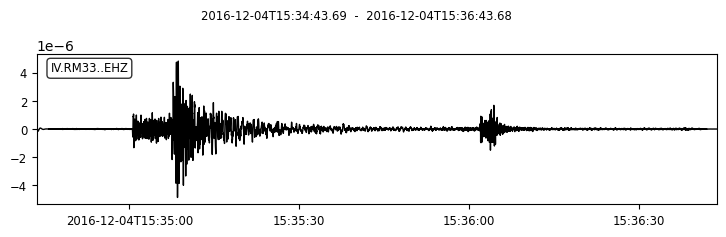

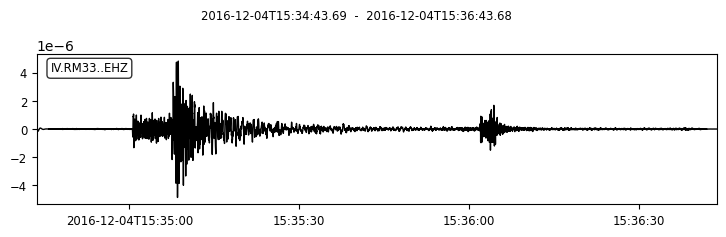

In [ ]:
events[8].plot()

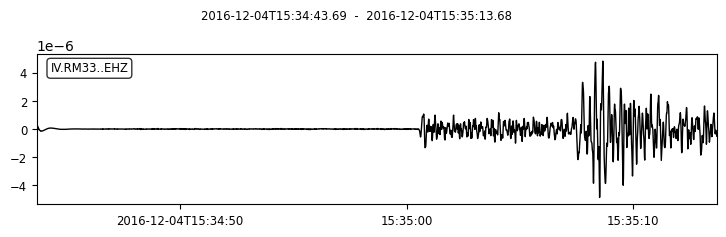

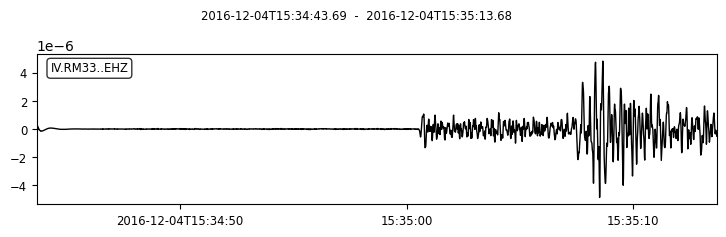

In [ ]:
sliced_traces[0].plot()

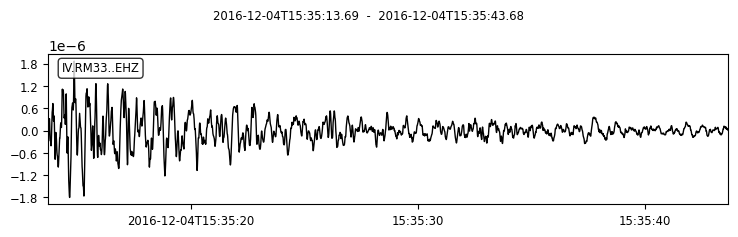

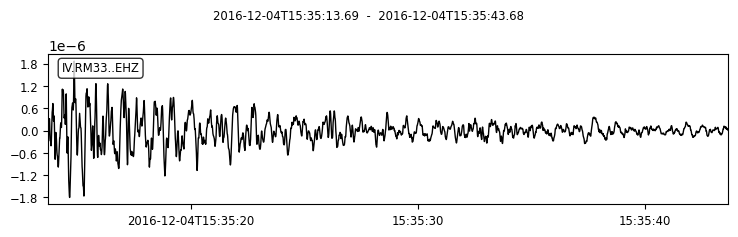

In [ ]:
sliced_traces[1].plot()

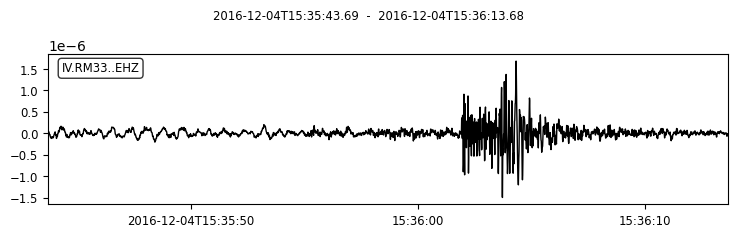

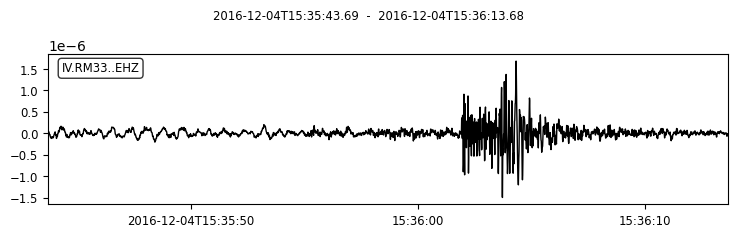

In [ ]:
sliced_traces[2].plot()

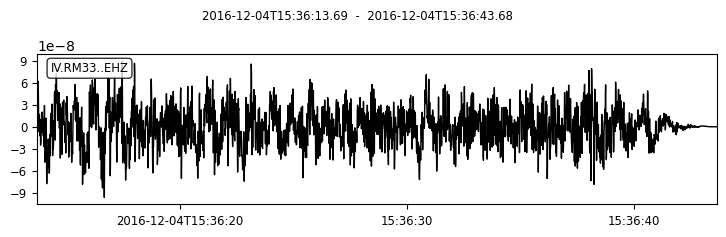

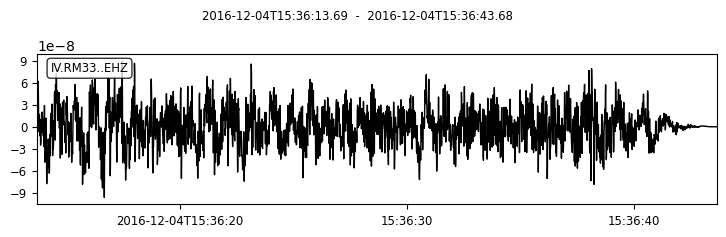

In [ ]:
sliced_traces[3].plot()

In [ ]:
test_stream = events[0:8]

In [ ]:
stream_sliced = stream_slice(test_stream)

Slice 0: P-phase at 17.35 seconds in window
Slice 0: P-phase at 17.35 seconds in window
Slice 0: P-phase at 17.35 seconds in window
Slice 0: P-phase at 18.76 seconds in window
Slice 0: P-phase at 18.76 seconds in window
Slice 0: P-phase at 18.76 seconds in window
Slice 0: P-phase at 16.79 seconds in window
Slice 0: S-phase at 23.66 seconds in window
Slice 0: P-phase at 16.79 seconds in window
Slice 0: S-phase at 23.66 seconds in window


In [ ]:
len(stream_sliced)

32

## noise sliced

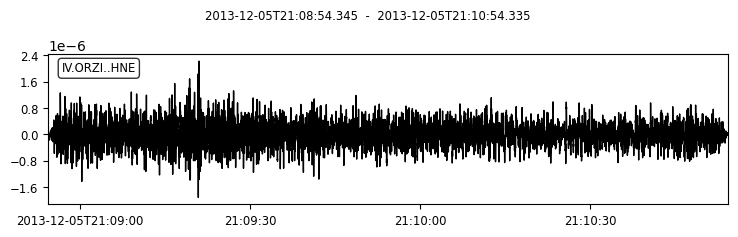

         network: IV
         station: ORZI
        location: 
         channel: HNE
       starttime: 2013-12-05T21:08:54.345000Z
         endtime: 2013-12-05T21:10:54.335000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 256278528})
      processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]

In [ ]:
noise[0].plot()
noise[0].stats

In [ ]:
sliced_noise = trace_slice_noise(noise[0])

In [ ]:
len(sliced_noise)

4

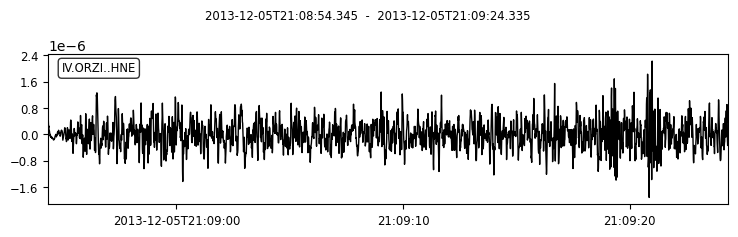

         network: IV
         station: ORZI
        location: 
         channel: HNE
       starttime: 2013-12-05T21:08:54.345000Z
         endtime: 2013-12-05T21:09:24.335000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 256278528})
      processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]

In [ ]:
sliced_noise[0].plot()
sliced_noise[0].stats

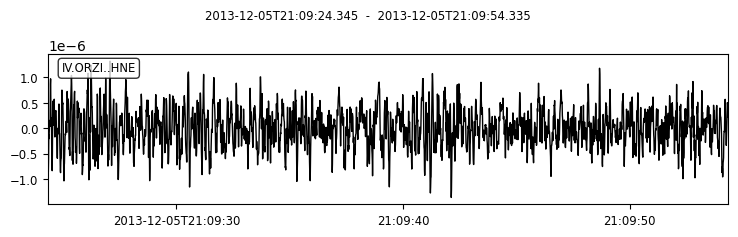

         network: IV
         station: ORZI
        location: 
         channel: HNE
       starttime: 2013-12-05T21:09:24.345000Z
         endtime: 2013-12-05T21:09:54.335000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 256278528})
      processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]

In [ ]:
sliced_noise[1].plot()
sliced_noise[1].stats

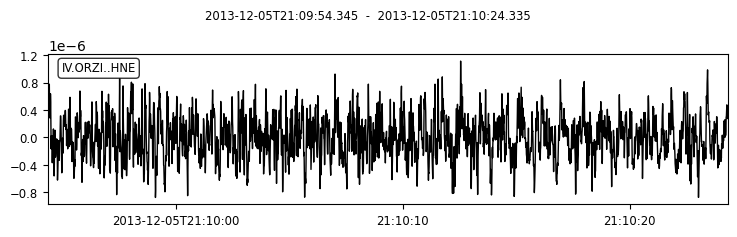

         network: IV
         station: ORZI
        location: 
         channel: HNE
       starttime: 2013-12-05T21:09:54.345000Z
         endtime: 2013-12-05T21:10:24.335000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 256278528})
      processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]

In [ ]:
sliced_noise[2].plot()
sliced_noise[2].stats

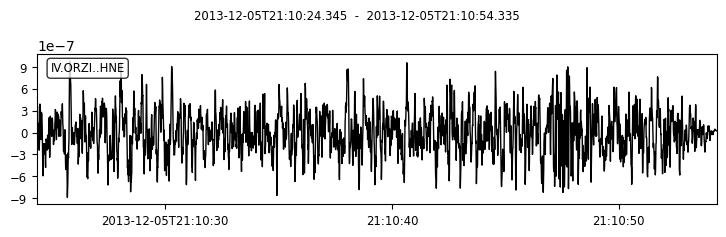

         network: IV
         station: ORZI
        location: 
         channel: HNE
       starttime: 2013-12-05T21:10:24.345000Z
         endtime: 2013-12-05T21:10:54.335000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 256278528})
      processing: ["ObsPy 1.4.2: filter(options={'freqmin': 1.0, 'freqmax': 45.0}::type='bandpass')"]

In [ ]:
sliced_noise[3].plot()
sliced_noise[3].stats

In [ ]:
test_stream = noise[0:8]

In [ ]:
stream_sliced = stream_slice_noise(test_stream)

In [ ]:
len(stream_sliced)

32

# feature extraction

## events feature extraction

In [ ]:
data = sliced_traces[0]

In [ ]:
events[8].id

'IV.RM33..EHZ'

In [ ]:
data.id

'IV.RM33..EHZ'

In [ ]:
time, freq = compute_dominant_frequencies(data, fs=100.0, window_length=200, hop_size=14, desired_frames=200, plot=False, title=None)

In [ ]:
print(freq)

[ 1.   1.   1.   1.   1.   1.   1.   1.   1.   0.5  0.5  0.5 23.5 23.5
 23.5 23.5  1.   1.   1.   1.   1.  23.5 23.5 23.5 23.5 23.5 23.5 23.5
 23.  23.  15.  15.  15.  22.5 23.5 23.5 23.  23.  23.  23.5 14.5 14.5
 14.5  1.5  1.5  1.5  1.   1.   1.   1.   0.5 16.5 16.5 16.5 16.5 24.
 24.   1.5  1.5  1.5  1.   1.   1.   1.   1.   1.   1.   1.   1.  21.5
 21.5 21.5 21.5 29.5 30.  23.5 23.5  0.5  0.5  0.5  1.   1.   1.   1.
  1.   0.5  0.5  0.5 15.  15.  15.  15.  15.  14.5  1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.5  1.5  1.5  1.5  1.5  1.5  3.5  4.   4.
  4.   4.   4.   4.   4.   3.5  3.5  3.5  3.5  3.5  3.5  3.   4.   4.
  4.5  4.5  4.5  4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.
  3.5  3.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  9.   8.5  8.5  8.5  3.5
  3.5  3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.5  3.5  3.5
  3.5  3.5  3.5  3.5  3.5  3.5  3.5  4.   4.   5.   5.   5.   5.   5.
  5.   5.5  5.5  5.5  5.5  5.5  2.5  2.5  2.5  2.5  2.5  2.5  4.   4.
  4.   3.5  3.

In [ ]:
len(time)

200

In [ ]:
len(freq)

200

In [ ]:
print(time)

[ 1.    1.14  1.28  1.42  1.56  1.7   1.84  1.98  2.12  2.26  2.4   2.54
  2.68  2.82  2.96  3.1   3.24  3.38  3.52  3.66  3.8   3.94  4.08  4.22
  4.36  4.5   4.64  4.78  4.92  5.06  5.2   5.34  5.48  5.62  5.76  5.9
  6.04  6.18  6.32  6.46  6.6   6.74  6.88  7.02  7.16  7.3   7.44  7.58
  7.72  7.86  8.    8.14  8.28  8.42  8.56  8.7   8.84  8.98  9.12  9.26
  9.4   9.54  9.68  9.82  9.96 10.1  10.24 10.38 10.52 10.66 10.8  10.94
 11.08 11.22 11.36 11.5  11.64 11.78 11.92 12.06 12.2  12.34 12.48 12.62
 12.76 12.9  13.04 13.18 13.32 13.46 13.6  13.74 13.88 14.02 14.16 14.3
 14.44 14.58 14.72 14.86 15.   15.14 15.28 15.42 15.56 15.7  15.84 15.98
 16.12 16.26 16.4  16.54 16.68 16.82 16.96 17.1  17.24 17.38 17.52 17.66
 17.8  17.94 18.08 18.22 18.36 18.5  18.64 18.78 18.92 19.06 19.2  19.34
 19.48 19.62 19.76 19.9  20.04 20.18 20.32 20.46 20.6  20.74 20.88 21.02
 21.16 21.3  21.44 21.58 21.72 21.86 22.   22.14 22.28 22.42 22.56 22.7
 22.84 22.98 23.12 23.26 23.4  23.54 23.68 23.82 23.96

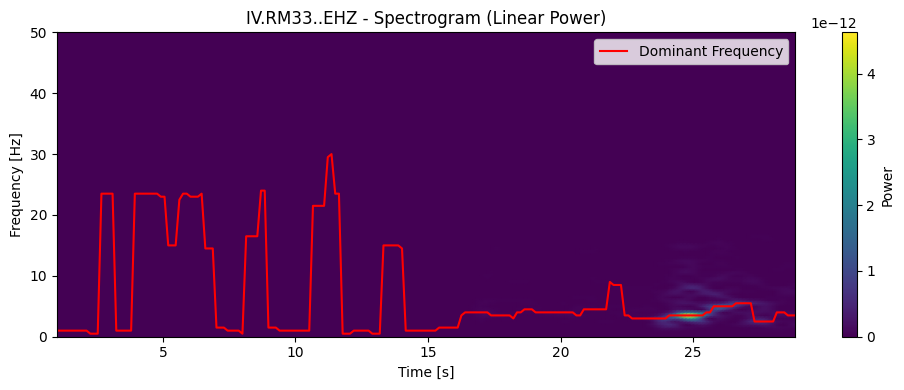

In [ ]:
t, freq = trace_dominant_frequencies(data, plot=True)

In [ ]:
len(t)

3000

In [ ]:
len(freq)

3000

In [ ]:
print(t[0:100])

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


In [ ]:
print(t[2900:])

[29.   29.01 29.02 29.03 29.04 29.05 29.06 29.07 29.08 29.09 29.1  29.11
 29.12 29.13 29.14 29.15 29.16 29.17 29.18 29.19 29.2  29.21 29.22 29.23
 29.24 29.25 29.26 29.27 29.28 29.29 29.3  29.31 29.32 29.33 29.34 29.35
 29.36 29.37 29.38 29.39 29.4  29.41 29.42 29.43 29.44 29.45 29.46 29.47
 29.48 29.49 29.5  29.51 29.52 29.53 29.54 29.55 29.56 29.57 29.58 29.59
 29.6  29.61 29.62 29.63 29.64 29.65 29.66 29.67 29.68 29.69 29.7  29.71
 29.72 29.73 29.74 29.75 29.76 29.77 29.78 29.79 29.8  29.81 29.82 29.83
 29.84 29.85 29.86 29.87 29.88 29.89 29.9  29.91 29.92 29.93 29.94 29.95
 29.96 29.97 29.98 29.99]


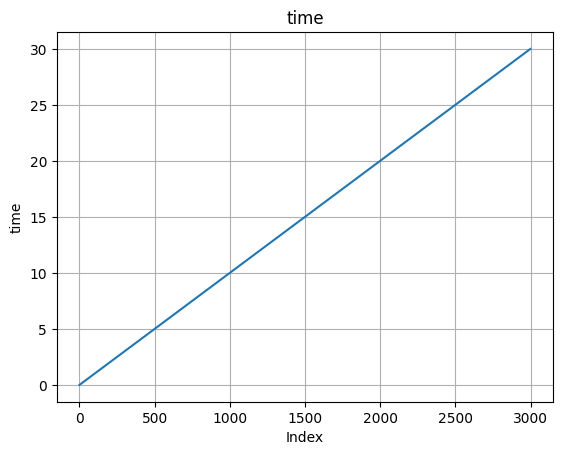

In [ ]:
plt.plot(t)
plt.xlabel("Index")  # You might want to adjust this label
plt.ylabel("time")
plt.title("time")
plt.grid(True)
plt.show()

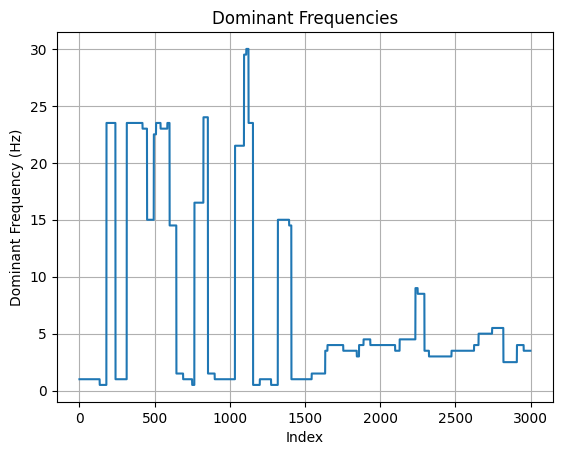

In [ ]:
plt.plot(freq)
plt.xlabel("Index")  # You might want to adjust this label
plt.ylabel("Dominant Frequency (Hz)")
plt.title("Dominant Frequencies")
plt.grid(True)
plt.show()

## noise feature extraction

In [ ]:
data_noise = sliced_noise[0]

In [ ]:
time_noise, freq_noise = compute_dominant_frequencies(data_noise, fs=100.0, window_length=100, hop_size=29, desired_frames=100, plot=False, title=None)

In [ ]:
len(time_noise)

100

In [ ]:
print(time_noise)

[ 0.5   0.79  1.08  1.37  1.66  1.95  2.24  2.53  2.82  3.11  3.4   3.69
  3.98  4.27  4.56  4.85  5.14  5.43  5.72  6.01  6.3   6.59  6.88  7.17
  7.46  7.75  8.04  8.33  8.62  8.91  9.2   9.49  9.78 10.07 10.36 10.65
 10.94 11.23 11.52 11.81 12.1  12.39 12.68 12.97 13.26 13.55 13.84 14.13
 14.42 14.71 15.   15.29 15.58 15.87 16.16 16.45 16.74 17.03 17.32 17.61
 17.9  18.19 18.48 18.77 19.06 19.35 19.64 19.93 20.22 20.51 20.8  21.09
 21.38 21.67 21.96 22.25 22.54 22.83 23.12 23.41 23.7  23.99 24.28 24.57
 24.86 25.15 25.44 25.73 26.02 26.31 26.6  26.89 27.18 27.47 27.76 28.05
 28.34 28.63 28.92 29.21]


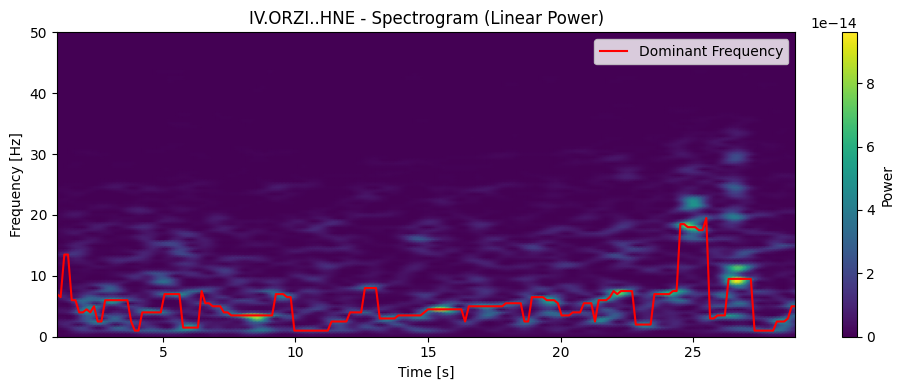

In [ ]:
t_noise, freq_noise = trace_dominant_frequencies(data_noise, plot=True)

In [ ]:
len(t_noise)

3000

In [ ]:
len(freq_noise)

3000

In [ ]:
print(t_noise[2900:])

[29.   29.01 29.02 29.03 29.04 29.05 29.06 29.07 29.08 29.09 29.1  29.11
 29.12 29.13 29.14 29.15 29.16 29.17 29.18 29.19 29.2  29.21 29.22 29.23
 29.24 29.25 29.26 29.27 29.28 29.29 29.3  29.31 29.32 29.33 29.34 29.35
 29.36 29.37 29.38 29.39 29.4  29.41 29.42 29.43 29.44 29.45 29.46 29.47
 29.48 29.49 29.5  29.51 29.52 29.53 29.54 29.55 29.56 29.57 29.58 29.59
 29.6  29.61 29.62 29.63 29.64 29.65 29.66 29.67 29.68 29.69 29.7  29.71
 29.72 29.73 29.74 29.75 29.76 29.77 29.78 29.79 29.8  29.81 29.82 29.83
 29.84 29.85 29.86 29.87 29.88 29.89 29.9  29.91 29.92 29.93 29.94 29.95
 29.96 29.97 29.98 29.99]


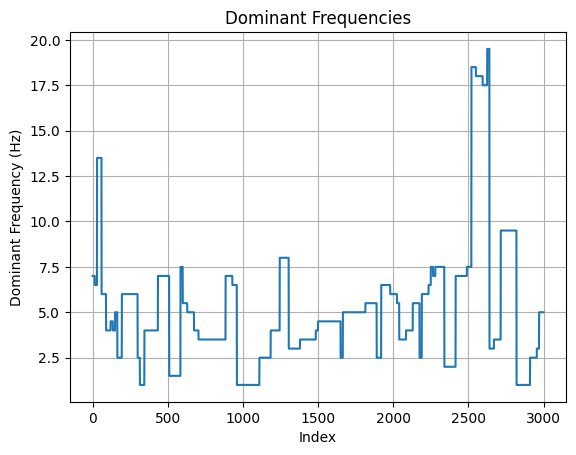

In [ ]:
plt.plot(freq_noise)
plt.xlabel("Index")  # You might want to adjust this label
plt.ylabel("Dominant Frequency (Hz)")
plt.title("Dominant Frequencies")
plt.grid(True)
plt.show()

# generate labels for each slice

## events labels

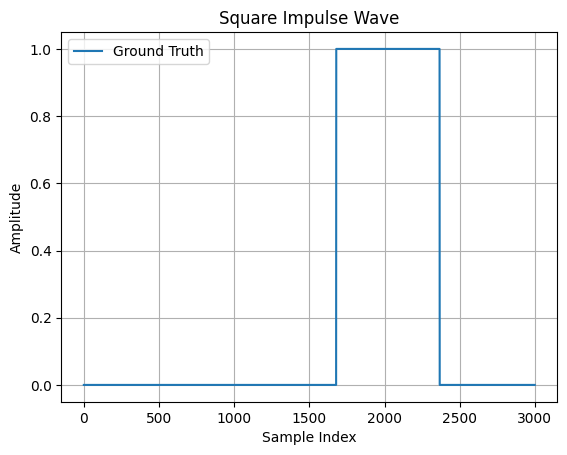

In [ ]:
time_label, wave = trace_labels(data, time=t, show=True)

In [ ]:
len(time_label)

3000

In [ ]:
print(time_label[0:100])

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


## noise labels

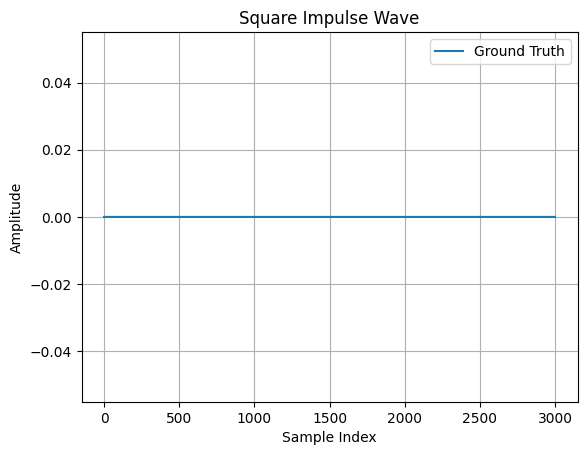

(array([0.000e+00, 1.000e-02, 2.000e-02, ..., 2.997e+01, 2.998e+01,
        2.999e+01]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
noise_labels(data_noise, time=time_label, show=True)

# notes

update apa aja yang dibenerin:
output trace_dominant_freq itu jadinya index/100

output dari labels itu waktu sebenarnya

jangan lupa benerin function di pipelines